# Introduction
- This was developed and tested on googlecolab. The reason for this is colab ships with tensorflow installed and runs on googles hardware, so this kept me from needing to set that up locally.

- I've commented the code heavily. Some of the comments are a bit obvious but i opted to stay on the safe side so you can see my thoughts when writing the code.

- To avoid errors, please run each cell in order, from top to bottom, and wait for each cell to complete running before moving on.

- I've wrapped a lot of the code into small, easily testable functions. I understand this isn't normal for ipython notebooks, but i figured it would be a good opportuntity to show how I write code. I understand every company does things a little different, and i'm open to new ideas as well.

- Either google colab or .ipynb files don't have full support for specifiying return types in function definitions, so I couldn't do that. Ex: `def example_function() -> List[str]:`

Okay, let's begin!

# 1. Generating sources.csv


In [55]:
# import libraries
import requests
import pandas as pd

# hardcode config file
# ideally, this would be read in as a file from a secure location
config = {
    "apiKey": "YOUR_NEWSAPI_APIKEY",
    "science_param": {"apiKey": "YOUR_NEWSAPI_APIKEY", "country": "us", "category": "science"},
    "business_param": {"apiKey": "YOUR_NEWSAPI_APIKEY", "country": "us", "category": "business"}
}

def generate_sources_csv(config: dict):
    """
    Generates sources.csv from config file.

    Args:
      config: contains an api key for the NewAPI and EXACTLY 2 parameters for
        making requests to the NewsAPI.
      example:

      {apiKey: "abc123",
        param1: {...},
        param2: {...}}

    Returns:
        None

    Raises:
        Exception: Error, response from api: business article api response
          code: 404. Science api response code: 404
    """
    # initialize variables
    df = pd.DataFrame()
    df_sci = pd.DataFrame()
    df_biz = pd.DataFrame()
    sources_endpoint = "https://newsapi.org/v2/top-headlines/sources?"
    # request data from api
    r_sci = requests.get(sources_endpoint, params=config["science_param"])
    r_biz = requests.get(sources_endpoint, params=config["business_param"])
    # decode json to a python dict
    r_sci = r_sci.json()
    r_biz = r_biz.json()
    # check api response for error codes
    if (r_sci["status"]=="ok" and r_biz["status"]=="ok"):
        df_sci = pd.DataFrame.from_records(r_sci["sources"])
        df_biz = pd.DataFrame.from_records(r_biz["sources"])
        # concatenate data into a single dataframe
        df = pd.concat([df_sci, df_biz])
        # generate csv file from dataframe
        df.to_csv("sources.csv", index=False)
    else:
        raise Exception("Error, response from api: business article api response code:", r_biz["status"], ". Science api response code:", r_sci["status"])


# run
generate_sources_csv(config=config)

# 2. Generating articles.csv

I've included this in a seperate cell, because in production i'd like it to run seperate from the app that generates the sources csv. The reason for this is that the generation of articles.csv relies on data from sources.csv, so we should validate that sources.csv has passed tests first.


In [56]:
# import libraries
from datetime import datetime, timedelta
from requests.models import Response

def get_three_days_ago():
    """
    Returns a string representing the date three days ago in YYYY-MM-DD format
    ex: "2022-12-25"

    Args:
      None

    Returns:
        None

    Raises:
        None
    """
    # find todays date
    today = datetime.now().date()
    # find the date three days ago
    three_days_ago = today - timedelta(days=3)
    # return the date three days ago as a string
    return str(three_days_ago)

def get_sources_list(sources_csv: str):
  """
  Returns the id column of sources.csv as a list. The id column
    contains the names of news sources, with dashes seperating words and
      lowercase spelling. Example: "national-geographic"

  Args:
    sources_csv: filename of sources.csv
    example:
      "sources.csv"

  Returns:
    a list containing the complete id column of sources.csv.
    example:
      ["national-geographic", "new-scientist", ... ]

  Raises:
    None
  """
  # initialize
  sources_list = []
  # read in csv file conaining news sources from NewsAPI
  sources_df = pd.read_csv(sources_csv)
  # iterate over the "id" column, appending each value to sources_list
  for index, row in sources_df.iterrows():
    sources_list.append(row["id"])
  # return sources_list
  return sources_list

def generate_articles_config(api_key: str):
    """
    Returns a dict containing an Api Key and query parameters used by the
    generate_articles_csv function

    Args:
      api_key: api key used to authenticate with the NewsAPI

    Returns:
        configuration dictionary of type dict[dict] where each key is a new
        param dict that will be used to configure a request to the NewsAPI
        example:
         {
          0: {
            "apiKey" : "abc123abc123",
            "sources" : "national-geographic",
            "from" : "2023-06-12"
            },
          1: {
            "apiKey" : "...",
            "sources" : "...",
            "from" : "..."
            }
        }
    """
    # initialize
    config = {}
    # dynamically generate date
    date = get_three_days_ago()
    # create a list from the sourceName column of sources.csv
    sources = get_sources_list("sources.csv")
    # populate config file
    for source in sources:
        params = {}
        params["apiKey"] = api_key
        params["sources"] = source
        params["from"] = date
        config[sources.index(source)] = params
    # return config
    return config


def clean_newsapi_response(api_response: Response):
  """
    Returns a clean, formatted list that can be used to create a pandas dataframe
    using the from_records() method. Also does some formatting.

    Args:
      api_response: Response object from requests.models containing data from
        the NewAPI

    Returns:
      articles_list: a list where each item is a row of data. Meant to be used
        to create a dataframe.
        example: pandas.DataFrame.from_records(articles_list)

    Raises:
      Exception: Error, reponse from api: 404

  """
  # decode json response to a dict
  api_response = api_response.json()
  # check that that the API responded without error codes
  if(api_response["status"]=="ok"):
    articles_list = api_response["articles"]
    for a in articles_list:
      # change {"id":"fortune","name":"Fortune"} to "Fortune"
      a["source"] = a["source"]["name"]
      # change "source" to "sourceName"
      a["sourceName"] = a.pop("source")
      # change "2023-06-13T00:00:00Z" to "2023-06-13"
      a["publishedAt"] = a["publishedAt"][0:10]
    return articles_list
  else:
    # if the api doesn't return status code 200, raise an exception
    raise Exception("Error, reponse from api:", api_response["status"])

def generate_articles_csv(config: dict):
  """
    Generates a csv containing articles from the NewsAPI from sources labelled
    as Business or Science.

    Args:
      config: dict where the value of each key contains parameters for a request
        to the News API.
        example:
        {
            0: {
              "apiKey" : "abc123abc123",
              "sources" : "national-geographic",
              "from" : "2023-06-12"
              },
            1: {
              "apiKey" : "...",
              "sources" : "...",
              "from" : "..."
              }
          }

    Returns:
        None

    Raises:
        Exception: asd

  """
  # create an empty dataframe to concatenate to
  df_list = []
  # define column order
  column_order = ["sourceName", "author","title",	"url",	"publishedAt"]

  # iterate through our configuration dict containing api request parameters
  for param in config:
      # send a request to the everything endpoint
      response = requests.get("https://newsapi.org/v2/everything?", params=config[param])
      # send API response to our data cleaning function
      clean_response = clean_newsapi_response(response)
      # create dataframe from clean_response, if response is not empty
      # response is empty when a given source has not published articles in the past 3 days
      if(len(clean_response) > 0):
        df = pd.DataFrame.from_records(clean_response)
        # drop unwanted columns
        df = df.drop(["description","content","urlToImage"], axis=1)
        # add df to our list of dataframes
        df_list.append(df)
  # combine our dataframes into a single dataframe
  df = pd.concat(df_list)
  # rearrange columns so that sourceName appears on the left
  df = df[column_order]
  # convert to csv
  df.to_csv("articles.csv", index=False)


articles_config = generate_articles_config(config["apiKey"])
generate_articles_csv(articles_config)

# 3. Applying the EmoRoBERTa model to our data

In [45]:
# install transformers, because google colab doesn't ship with it
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00


### Loading and testing the model
Here we use some example code from the documentation to test that the model is running as expected.

[documentation](https://huggingface.co/arpanghoshal/EmoRoBERTa)

In [46]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis',
                    model='arpanghoshal/EmoRoBERTa')

emotion_labels = emotion("Thanks for using it.")
print(emotion_labels)


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'label': 'gratitude', 'score': 0.9964383840560913}]


## Applying the model to article titles
Now that we have sources.csv and articles.csv, we can apply our model to article titles.

Here we add 2 new columns to our dataframe:
1. *sentiment* - STRING - contains the sentiment analysis label from EmoRoBERTa
2. *timeToClassify* - FLOAT - the time, in seconds, it took for our model to classify the article title

In [47]:
import time

def generate_sentiment_analysis_df(articles_csv: str):
  """
  Generates a dataframe for analysis of the performance of the EmoRoBERTa
  model against article titles from the News API.

  Args:
    articles_csv: filename of articles.csv
      example: "articles.csv"

  Returns:
      List[Pandas.Dataframe, float]

      List containing the sentiment analysis dataframe, and "total_time", a
      float representing the total time EmoRoBerta took to classify all
      article titles in articles.csv

  Raises:
      None

  """
  # initialize
  total_time = 0
  # read in articles.csv
  df = pd.read_csv(articles_csv)
  # initialize new columns
  df["sentiment"] = None
  df["secondsToClassify"] = None
  # iterate over dataframe while applying model and recording runtimes
  for index, row in df.iterrows():
      # start timer
      start_time = time.time()
      # classify a single title
      emotion_labels = emotion(row["title"])
      # end timer
      end_time = time.time()
      # add to total_time before rounding
      elapsed_time = end_time - start_time
      total_time += elapsed_time
      # round to 1 decimal points
      elapsed_time = "{:.1f}".format(elapsed_time)
      # add sentiment and secondsToClassify column to dataframe
      df.at[index, "sentiment"] = emotion_labels[0]["label"]
      df.at[index, "secondsToClassify"] = elapsed_time

  # format total time to 3 decimal points
  total_time = "{:.3f}".format(total_time)

  # return dataframe and total_time so we can do some analysis
  return [df,total_time]


# run
results = generate_sentiment_analysis_df("articles.csv")


### total time to classify and individual classification times

In [50]:
# grab sentiment_analysis dataframe from results
df = results[0]
# grab total_time from results
total_time = results[1]
seconds_per_article = float(total_time) / len(df["title"])
# print total_time and seconds_per_article
print("total time to classify", len(df["title"]) ,"titles:", total_time)
print("seconds per article:", seconds_per_article)
print("\n\n value counts of secondsToClassify column")
print(df["secondsToClassify"].value_counts())

total time to classify 264 titles: 125.406
seconds per article: 0.4750227272727273


 value counts of secondsToClassify column
0.4    101
0.3     65
0.6     30
0.5     26
0.7     18
0.8     10
0.9      5
1.1      3
1.0      2
1.3      2
1.2      1
1.4      1
Name: secondsToClassify, dtype: int64


# 4. Analysis!
Let's see what interesting conclusions we can draw from our sentiment analysis data.

## Graph 1: Classificaiton time in seconds for all articles titles

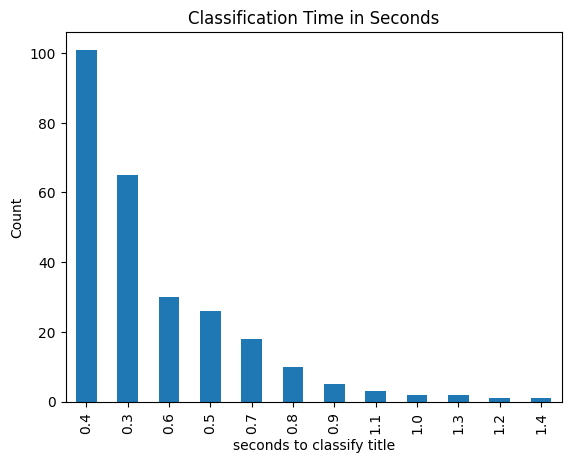

In [51]:
import matplotlib.pyplot as plt

counts = df["secondsToClassify"].value_counts()

# Visualize the counts using a bar plot
counts.plot(kind="bar")
plt.xlabel("seconds to classify title")
plt.ylabel("Count")
plt.title("Classification Time in Seconds")
plt.show()


### Analysis
After running this graph for a few days, I see big differences in the upper range of time our model took to classify a single article title. It can range from 1.2 to 2.0 seconds. However, importantly, the distribution of classification times remains fairly constant, with the vast vajority being classified in less than 0.3 seconds.
Possible variables effecting classification times:
- total number are articles
- articles title length
- google hardware (google colab runs on free-tier gcp resources, which are not consistently available)

It would be interesting to see if the distribution changes with a larger sample size, and a dedicated vm.

# Graph 2: Neutrality of Business and Science Sources in a 3 Day Range



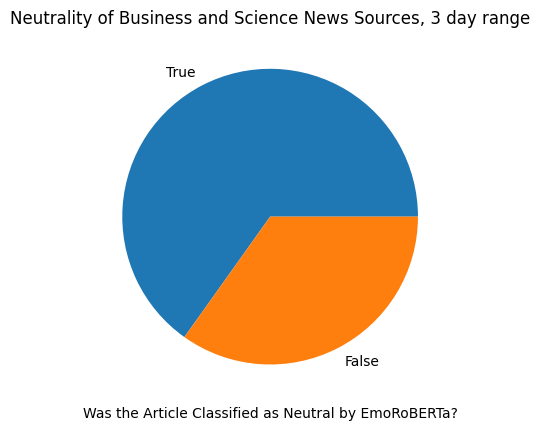

True     172
False     92
Name: neutral, dtype: int64


In [52]:
import matplotlib.pyplot as plt

# initialize new column
df["neutral"] = None

# iterate over dataframe
for index, row in df.iterrows():
  # if sentiment is "neutral", put True. If not "neutral", put False.
  if df.at[index, "sentiment"] == "neutral":
    df.at[index, "neutral"] = True
  else:
    df.at[index, "neutral"] = False

# see how many article_titles were classiffied as neutral, vs not neutral.
neutrality = df["neutral"].value_counts()

# Visualize the counts using a pie graph
neutrality.plot(kind="pie")
plt.xlabel("Was the Article Classified as Neutral by EmoRoBERTa?")
plt.ylabel("")

plt.title("Neutrality of Business and Science News Sources, 3 day range")
plt.show()

# Display the counts
print(neutrality)

### Analysis
So first I want to talk about my thinking behind classifying articles as neutral or not, and ignoring the other labels. When it comes to news, especially
business or science news, we expect a degree of neutrality. This is different from other categories, like, for example, politics or entertainment. We expect news like that to be delivered to us with a bit of an *opinion* attached.

Of course, this isn't the reality. News sources of all types are incentivised to make titles dramatic in order to entice people to click. So, I decided to look at the neutrality of news sources.

Here we see that 38% of business and science article titles in the last 3 days were classified as "not neutral".

Ideas for further analysis, given a larger date range:
- neutrality by news source
- neutrality by author
- neutrality of Business sources vs Science sources

In [53]:
# number of articles per source (in the last three days)
df["sourceName"].value_counts()

Business Insider           100
Fortune                    100
New Scientist               27
National Geographic         18
Next Big Future             14
The Wall Street Journal      5
Name: sourceName, dtype: int64

# 5. Creating a BigQuery Schema
According to the documentation, you can specify a schema for a bigquery table using json, or using a sql `CREATE TABLE` statement. I've opted to use a sql statement.
- This is meant to be run as a sql query in the BigQuery web ui.
- Replace `mydataset` with a valid dataset.
```
CREATE TABLE IF NOT EXISTS mydataset.analysis (
  sourceName STRING OPTIONS(description="News source name. Ex: National Geographic"),
  author STRING OPTIONS(description="Author name. Ex: William Dafoe"),
  title STRING OPTIONS(description="Article title"),
  url	STRING OPTIONS(description="URL of article"),
  publishedAt DATETIME OPTIONS(description="Date and time that the article was published. Ex: 2023-06-12"),
  sentiment STRING OPTIONS(description="the label assigned by the EmoRoBERTa model. ex: neutral"),
  secondsToClassify FLOAT64 OPTIONS(description="the seconds it took for the EmoRoBERTa model to classify each article title, rounded to 1 decimal point. Ex: 0.3"),
)
OPTIONS(
  description = 'Table containing articles from news sources categorized as business or science, from the last three days. Date is generated dynamically. Source: NewsAPI'
);
```

# 6. Writing a SQL query for that calculates the average time it takes to generate a prediction from the model grouped by publishing date

- replace PROJECT-NAME and DATASET-NAME with a valid project and dataset
```
SELECT AVG(secondsToClassify), publishedAt
FROM `PROJECT-NAME.DATASET-NAME.analysis`
GROUP BY publishedAt
```